In [183]:
%matplotlib inline

import h5py
import numpy as np
from matplotlib import pyplot as plt
import torch
from fastmri.data import transforms as T
from fastmri.data.subsample import RandomMaskFunc
from utils_dont_remove import tensor_to_complex_np
from pygrappa import grappa
from skimage.metrics import structural_similarity

def ssim(gt, pred):
    """ Compute Structural Similarity Index Metric (SSIM). """
    return structural_similarity(
        gt.transpose(1, 2, 0), pred.transpose(1, 2, 0), multichannel=True, data_range=gt.max()
    )

def ifft(input, signal_ndim, normalized=True):
        return torch.view_as_real(torch.fft.ifft2(
            torch.view_as_complex(input),
            norm="ortho" if normalized else "backward"))
    

def show_coils(data, slice_nums, cmap=None):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)
def kspace_to_image(slice_kspace):
    """
    Transfroms kspace data to real-valued image.
    Args:
        slice_kspace (numpy.array): Multi-coil input k-space of shape (num_coils, rows, cols) 
    Returns:
        image: (numpy.array): Multi-channel image of shape (num_coils, rows, cols)
    """
    slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
    slice_image = ifft2(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
    slice_image_abs = complex_abs(slice_image)   # Compute absolute value to get a real image
    return slice_image_abs

def ifftshift(x, dim=None):
    """
    Similar to np.fft.ifftshift but applies to PyTorch Tensors
    """
    if dim is None:
        dim = tuple(range(x.dim()))
        shift = [(dim + 1) // 2 for dim in x.shape] #TODO: looks wrong
    elif isinstance(dim, int):
        shift = (x.shape[dim] + 1) // 2
    else:
        shift = [(x.shape[i] + 1) // 2 for i in dim]
    return roll(x, shift, dim)

def ifft2(data):
    """
    Apply centered 2-dimensional Inverse Fast Fourier Transform.
    Args:
        data (torch.Tensor): Complex valued input data containing at least 3 dimensions: dimensions
            -3 & -2 are spatial dimensions and dimension -1 has size 2. All other dimensions are
            assumed to be batch dimensions.
    Returns:
        torch.Tensor: The IFFT of the input.
    """
    assert data.size(-1) == 2
    data = ifftshift(data, dim=(-3, -2))
    data = ifft(data, 2, normalized=True)
    data = fftshift(data, dim=(-3, -2))
    return data

def roll(x, shift, dim):
    """
    Similar to np.roll but applies to PyTorch Tensors
    """
    if isinstance(shift, (tuple, list)):
        assert len(shift) == len(dim)
        for s, d in zip(shift, dim):
            x = roll(x, s, d)
        return x
    shift = shift % x.size(dim)
    if shift == 0:
        return x
    left = x.narrow(dim=dim, start=0, length=x.size(dim) - shift)
    right = x.narrow(dim=dim, start=x.size(dim) - shift, length=shift)
    return torch.cat((right, left), dim=dim)


def fftshift(x, dim=None):
    """
    Similar to np.fft.fftshift but applies to PyTorch Tensors
    """
    if dim is None:
        dim = tuple(range(x.dim()))
        shift = [dim // 2 for dim in x.shape]
    elif isinstance(dim, int):
        shift = x.shape[dim] // 2
    else:
        shift = [x.shape[i] // 2 for i in dim]
    return roll(x, shift, dim)

def complex_abs(data):
    """
    Compute the absolute value of a complex valued input tensor.

    Args:
        data (torch.Tensor): A complex valued tensor, where the size of the final dimension
            should be 2.

    Returns:
        torch.Tensor: Absolute value of data
    """
    assert data.size(-1) == 2
    return ((data ** 2).sum(dim=-1) + 0.0).sqrt()

In [184]:

file_name = 'multicoil_values/file_brain_AXFLAIR_200_6002425-Copy1.h5'
hf = h5py.File(file_name)
volume_kspace = hf['kspace'][()]
slice_kspace = volume_kspace[10] # Choosing the 20-th slice of this volume
print(slice_kspace.dtype)
print(slice_kspace.shape)

complex64
(20, 640, 320)


/tmp/ipykernel_8875/1208562373.py:2: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  hf = h5py.File(file_name)


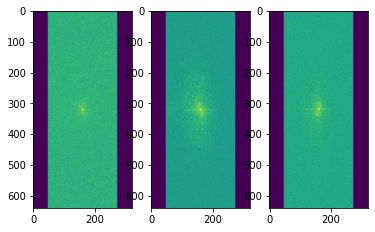

In [185]:
slice_kspace_image = show_coils(np.log(np.abs(slice_kspace) + 1e-9), [0, 5, 10])  # This shows coils 0, 5 and 10

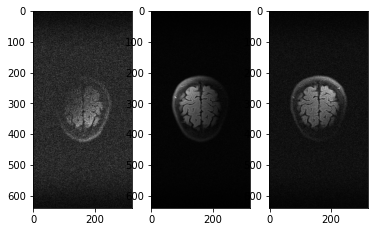

In [186]:
slice_real= kspace_to_image(slice_kspace)
show_coils(slice_real, [0, 5, 10], cmap='gray')

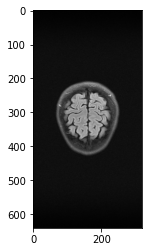

In [187]:
import fastmri
from fastmri.data import transforms as T
slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image
#show_coils(slice_image_abs, [0, 5, 10], cmap='gray')
#As we can see, each coil in a multi-coil MRI scan focusses on a different region of the image. These coils can be combined into the full image using the Root-Sum-of-Squares (RSS) transform.

ground_truth = fastmri.rss(slice_image_abs, dim=0)
plt.imshow(np.abs(ground_truth.numpy()), cmap='gray')

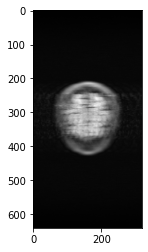

In [188]:
from fastmri.data.subsample import RandomMaskFunc
mask_func = RandomMaskFunc(center_fractions=[0.04], accelerations=[8])  # Create the mask function object
masked_kspace_8x, mask = T.apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space

sampled_image = fastmri.ifft2c(masked_kspace)           # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image
sampled_image_rss_masked_8x = fastmri.rss(sampled_image_abs, dim=0)

#masked = fastmri.rss(slice_image_abs, dim=0)
plt.imshow(np.abs(sampled_image_rss_masked_8x.numpy()), cmap='gray')

SSIM between masked and gt at 8x = 0.6089053113567843


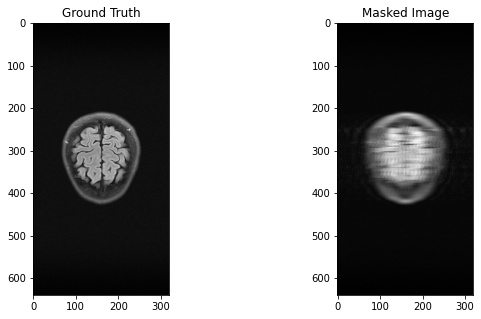

In [189]:
sampled_image = fastmri.ifft2c(masked_kspace_8x)           # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image
sampled_image_rss_masked_8x = fastmri.rss(sampled_image_abs, dim=0)

def ssim(gt, pred):
       
    return structural_similarity(
        gt, pred, multichannel=False, data_range=gt.max(), win_size=11
    )
    

ssim = ssim(np.abs(ground_truth.numpy()),np.abs(sampled_image_rss_masked_8x.numpy()))
print("SSIM between masked and gt at 8x = " + str(ssim))


# Display the images side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(ground_truth, cmap='gray')
ax[0].set_title('Ground Truth')
ax[1].imshow(np.abs(sampled_image_rss_masked_8x.numpy()), cmap='gray')
ax[1].set_title('Masked Image')
plt.show()

SSIM between masked and gt at 4x = 0.7449009381489247


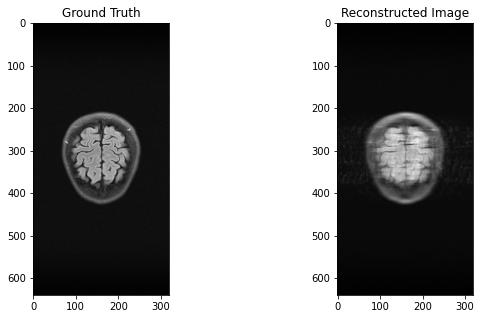

In [288]:
from fastmri.data.subsample import RandomMaskFunc
mask_func2 = RandomMaskFunc(center_fractions=[0.04], accelerations=[4])  # Create the mask function object
masked_kspace_4x, mask = T.apply_mask(slice_kspace2, mask_func2) 

sampled_image = fastmri.ifft2c(masked_kspace_4x)           # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image
sampled_image_rss_masked_4x = fastmri.rss(sampled_image_abs, dim=0)

def ssim(gt, pred):
       
    return structural_similarity(
        gt, pred, multichannel=False, data_range=gt.max(), win_size=11
    )
    

my_ssim = ssim(np.abs(ground_truth.numpy()),np.abs(sampled_image_rss_masked_4x.numpy()))
print("SSIM between masked and gt at 4x = " + str(my_ssim ))


# Display the images side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(ground_truth, cmap='gray')
ax[0].set_title('Ground Truth')
ax[1].imshow(np.abs(sampled_image_rss_masked_4x.numpy()), cmap='gray')
ax[1].set_title('Reconstructed Image')
plt.show()

Time spent on apply_grappa: 5.959454536437988 seconds
SSIM after applying grappa to 4x = 0.7702158298767406


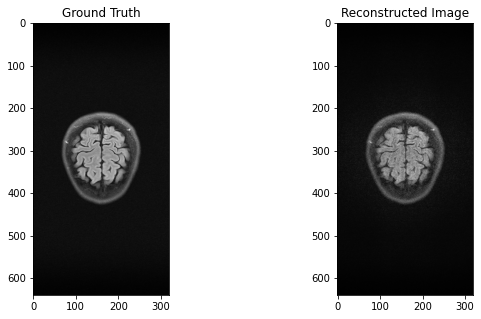

In [286]:
def apply_grappa(masked_kspace, mask):
    """
    Applies GRAPPA algorithm
    References
    ----------
    [1] Griswold, Mark A., et al. "Generalized autocalibrating
       partially parallel acquisitions (GRAPPA)." Magnetic
       Resonance in Medicine: An Official Journal of the
       International Society for Magnetic Resonance in Medicine
       47.6 (2002): 1202-1210.
    Args:
        masked_kspace (torch.Tensor): Multi-coil masked input k-space of shape (num_coils, rows, cols, 2)
        mask (torch.Tensor): Applied mask of shape (1, 1, cols, 1)
    Returns:
        preprocessed_masked_kspace (torch.Tensor): Output of GRAPPA algorithm applied on masked_kspace
    """

    def get_low_frequency_lines(mask):
        l = r = mask.shape[-2] // 2
        while mask[..., r, :]:
            r += 1

        while mask[..., l, :]:
            l -= 1

        return l + 1, r

    l, r = get_low_frequency_lines(mask)
    num_low_freqs = r - l
    pad = (mask.shape[-2] - num_low_freqs + 1) // 2
    calib = masked_kspace[:, :, pad:pad + num_low_freqs].clone()
    preprocessed_masked_kspace = grappa(tensor_to_complex_np(masked_kspace), tensor_to_complex_np(calib), kernel_size=(5, 5), coil_axis=0)
    return T.to_tensor(preprocessed_masked_kspace)

import time

# Measure time spent on apply_grappa
start_time = time.time()
grappa_kspace = apply_grappa(masked_kspace_4x, mask)
end_time = time.time()
elapsed_time = end_time - start_time
print("Time spent on apply_grappa: " + str(elapsed_time) + " seconds")


sampled_image = fastmri.ifft2c(grappa_kspace)           # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image
sampled_image_rss_grappa_4x = fastmri.rss(sampled_image_abs, dim=0)

my_ssim  = ssim(np.abs(ground_truth.numpy()),np.abs(sampled_image_rss_grappa_4x.numpy()))
print("SSIM after applying grappa to 4x = " + str(my_ssim))

# Display the images side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(ground_truth, cmap='gray')
ax[0].set_title('Ground Truth')
ax[1].imshow(np.abs(sampled_image_rss_grappa_4x.numpy()), cmap='gray')
ax[1].set_title('Reconstructed Image')
plt.show()

SSIM after applying grappa to 8x = 0.6861003183647907


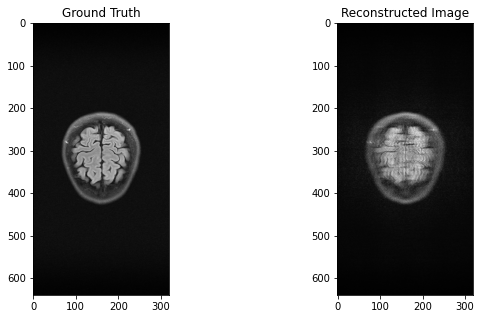

In [240]:

grappa_kspace = apply_grappa(masked_kspace_8x, mask)
sampled_image = fastmri.ifft2c(grappa_kspace)           # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image
sampled_image_rss_grappa_8x = fastmri.rss(sampled_image_abs, dim=0)

my_ssim  = ssim(np.abs(ground_truth.numpy()),np.abs(sampled_image_rss_grappa_8x.numpy()))
print("SSIM after applying grappa to 8x = " + str(my_ssim))

# Display the images side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(ground_truth, cmap='gray')
ax[0].set_title('Ground Truth')
ax[1].imshow(np.abs(sampled_image_rss_grappa_8x.numpy()), cmap='gray')
ax[1].set_title('Reconstructed Image')
plt.show()

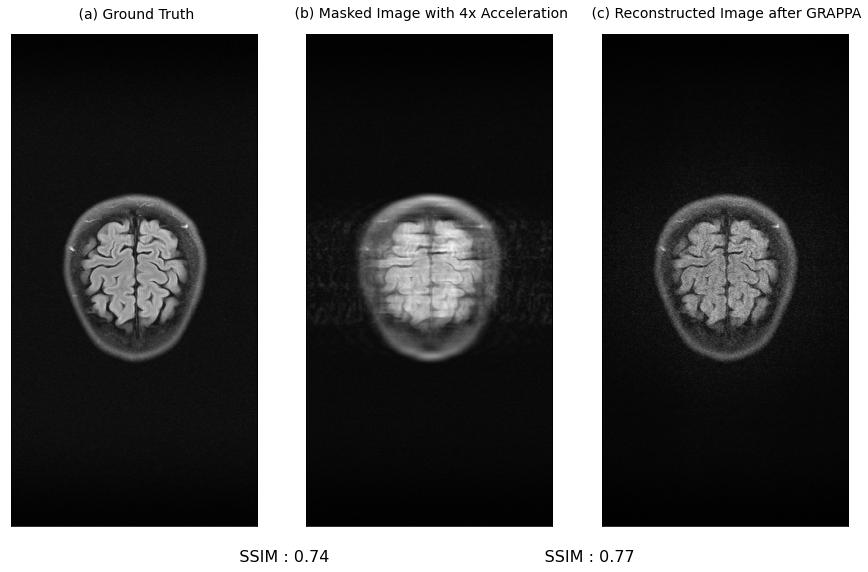

In [289]:
fig, axs = plt.subplots(1, 3, figsize=(15, 20))
# Display the images in the subplots
axs[0].imshow(ground_truth, cmap='gray')
axs[0].set_title(" (a) Ground Truth",fontsize=14, y=1.02)

axs[1].imshow(sampled_image_rss_masked_4x, cmap='gray')
axs[1].set_title(" (b) Masked Image with 4x Acceleration",fontsize=14, y=1.02)

axs[2].imshow(sampled_image_rss_grappa_4x, cmap='gray')
axs[2].set_title(" (c) Reconstructed Image after GRAPPA",fontsize=14, y=1.02)

# Hide the tick labels and axis labels
for ax in axs.flatten():
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

fig.suptitle("   SSIM : 0.74                                          SSIM : 0.77 ", fontsize=16, y= 0.315, x=0.515)
# Show the plot
plt.show()

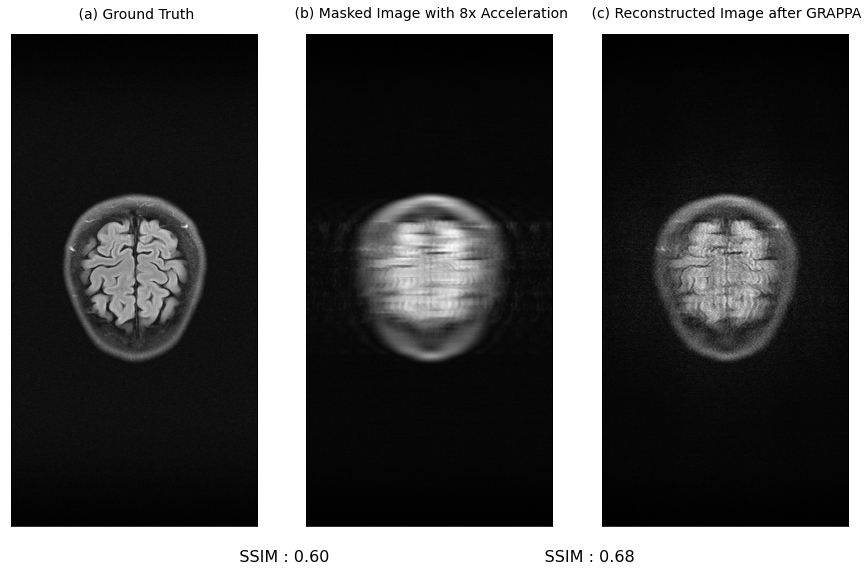

In [284]:
fig, axs = plt.subplots(1, 3, figsize=(15, 20))
# Display the images in the subplots
axs[0].imshow(ground_truth, cmap='gray')
axs[0].set_title(" (a) Ground Truth",fontsize=14, y=1.02)

axs[1].imshow(sampled_image_rss_masked_8x, cmap='gray')
axs[1].set_title(" (b) Masked Image with 8x Acceleration",fontsize=14, y=1.02)

axs[2].imshow(sampled_image_rss_grappa_8x, cmap='gray')
axs[2].set_title(" (c) Reconstructed Image after GRAPPA",fontsize=14, y=1.02)

# Hide the tick labels and axis labels
for ax in axs.flatten():
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

fig.suptitle("   SSIM : 0.60                                          SSIM : 0.68 ", fontsize=16, y= 0.315, x=0.515)
# Show the plot
plt.show()

In [301]:
import os

folder_path = 'multicoil_values/multicoil_train'
prefix = 'file_brain_'

# Initialize a dictionary to keep track of the counts for each file name
file_counts = {}

# Get a list of all files in the specified directory
file_list = os.listdir(folder_path)

# Loop through each file and count the number of times each file name appears
for file_name in file_list:
    if file_name.startswith(prefix):
        # Extract the part of the file name after the prefix
        suffix = file_name[len(prefix):]
        
        # Remove all non-digit characters from the suffix
        suffix = ''.join(filter(str.isdigit, suffix))
        
        # Add the prefix to the dictionary and increment the count
        prefix_count = file_counts.get(prefix, 0)
        file_counts[prefix] = prefix_count + 1

# Print the total count and the count for each file name
total_count = sum(file_counts.values())
print("Total count:", total_count)

for el in file_list:
    print(el)

Total count: 4613
file_brain_AXT2_202_2020067.h5
file_brain_AXT2_207_2070142.h5
file_brain_AXT2_209_6001191.h5
file_brain_AXT2_201_2010463.h5
file_brain_AXT2_200_6002178.h5
file_brain_AXT1POST_202_6000541.h5
file_brain_AXT2_210_6001944.h5
file_brain_AXT2_208_2080668.h5
file_brain_AXFLAIR_200_6002507.h5
file_brain_AXT1POST_207_2070365.h5
file_brain_AXT1POST_202_6000318.h5
file_brain_AXT2_200_6001999.h5
file_brain_AXT2_209_2090159.h5
file_brain_AXT1POST_206_6000249.h5
file_brain_AXFLAIR_202_6000477.h5
file_brain_AXT2_210_2100293.h5
file_brain_AXT1_202_2020486.h5
file_brain_AXT1_202_6000284.h5
file_brain_AXT2_200_6002116.h5
file_brain_AXT2_209_6001314.h5
file_brain_AXT1POST_210_6001825.h5
file_brain_AXT2_202_2020226.h5
file_brain_AXT2_207_2070781.h5
file_brain_AXT1POST_208_2080115.h5
file_brain_AXT2_207_2070602.h5
file_brain_AXT1_202_6000445.h5
file_brain_AXFLAIR_201_6002917.h5
file_brain_AXT2_209_2090392.h5
file_brain_AXT2_208_2080364.h5
file_brain_AXT2_200_6002375.h5
file_brain_AXT2_208

file_brain_AXT2_200_6001980.h5
file_brain_AXT1PRE_203_6000860.h5
file_brain_AXT2_203_2030188.h5
file_brain_AXT2_201_2010360.h5
file_brain_AXT1PRE_200_6002247.h5
file_brain_AXT2_203_2030131.h5
file_brain_AXT2_202_2020268.h5
file_brain_AXT2_209_6001248.h5
file_brain_AXT2_200_2000032.h5
file_brain_AXT1POST_205_6000015.h5
file_brain_AXFLAIR_201_6003015.h5
file_brain_AXT2_210_6001603.h5
file_brain_AXT1_202_2020032.h5
file_brain_AXT2_207_2070011.h5
file_brain_AXT2_209_6001368.h5
file_brain_AXT1POST_202_6000592.h5
file_brain_AXT2_202_2020020.h5
file_brain_AXFLAIR_203_6000898.h5
file_brain_AXT2_210_6001826.h5
file_brain_AXT1POST_200_6002004.h5
file_brain_AXT2_209_2090070.h5
file_brain_AXT1_202_2020301.h5
file_brain_AXT1POST_208_2080032.h5
file_brain_AXT2_210_6001890.h5
file_brain_AXT2_208_2080440.h5
file_brain_AXT1POST_200_6002342.h5
file_brain_AXT2_207_2070595.h5
file_brain_AXT1POST_210_6001872.h5
file_brain_AXT2_210_6001566.h5
file_brain_AXT2_206_2060007.h5
file_brain_AXT1POST_202_6000354.h5

file_brain_AXT1POST_207_2070083.h5
file_brain_AXT2_210_2100308.h5
file_brain_AXT2_203_2030404.h5
file_brain_AXT2_200_2000326.h5
file_brain_AXT2_200_6002424.h5
file_brain_AXT1_202_6000305.h5
file_brain_AXT2_207_2070066.h5
file_brain_AXT2_202_2020401.h5
file_brain_AXT2_200_2000301.h5
file_brain_AXFLAIR_200_6002541.h5
file_brain_AXT1POST_208_2080302.h5
file_brain_AXT2_200_2000285.h5
file_brain_AXT1_202_2020388.h5
file_brain_AXT2_209_2090314.h5
file_brain_AXT1POST_208_2080227.h5
file_brain_AXT2_200_6002470.h5
file_brain_AXT2_202_2020269.h5
file_brain_AXT2_207_2070289.h5
file_brain_AXT1POST_207_2070259.h5
file_brain_AXT1_201_6002834.h5
file_brain_AXT1POST_207_2070014.h5
file_brain_AXT2_202_6000397.h5
file_brain_AXT2_202_2020316.h5
file_brain_AXT1POST_201_6002792.h5
file_brain_AXT2_202_2020015.h5
file_brain_AXT2_200_2000388.h5
file_brain_AXT2_202_2020458.h5
file_brain_AXT2_209_6001349.h5
file_brain_AXT2_209_2090353.h5
file_brain_AXT1PRE_203_6000721.h5
file_brain_AXT1_202_2020455.h5
file_brai

In [336]:
import os
import random

folder_path = 'multicoil_values/multicoil_train'

# Define a list of substrings to search for
search_substrings = ['AXT2', 'AXT1POST', 'AXT1PRE', 'AXFLAIR', 'AXT1_']

# Initialize a dictionary to store the file names for each substring
file_names = {}

# Get a list of all files in the specified directory
file_list = os.listdir(folder_path)

# Loop through each file and store its name if it contains any of the search substrings
for file_name in file_list:
    for substring in search_substrings:
        if substring in file_name.upper():
            file_names[substring] = os.path.join(folder_path, file_name)

# Select a random file name for each substring and store it in a dictionary
selected_files = {}
for substring in search_substrings:
    if substring in file_names:
        selected_files[file_names[substring]] = file_names[substring]
    else:
        print(f"No file found for substring '{substring}'")
        
print(selected_files)

{'multicoil_values/multicoil_train/file_brain_AXT2_202_2020528.h5': 'multicoil_values/multicoil_train/file_brain_AXT2_202_2020528.h5', 'multicoil_values/multicoil_train/file_brain_AXT1POST_207_2070114.h5': 'multicoil_values/multicoil_train/file_brain_AXT1POST_207_2070114.h5', 'multicoil_values/multicoil_train/file_brain_AXT1PRE_203_6000707.h5': 'multicoil_values/multicoil_train/file_brain_AXT1PRE_203_6000707.h5', 'multicoil_values/multicoil_train/file_brain_AXFLAIR_200_6002570.h5': 'multicoil_values/multicoil_train/file_brain_AXFLAIR_200_6002570.h5', 'multicoil_values/multicoil_train/file_brain_AXT1_202_2020568.h5': 'multicoil_values/multicoil_train/file_brain_AXT1_202_2020568.h5'}


/tmp/ipykernel_8875/693286685.py:13: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  hf = h5py.File(file_name)


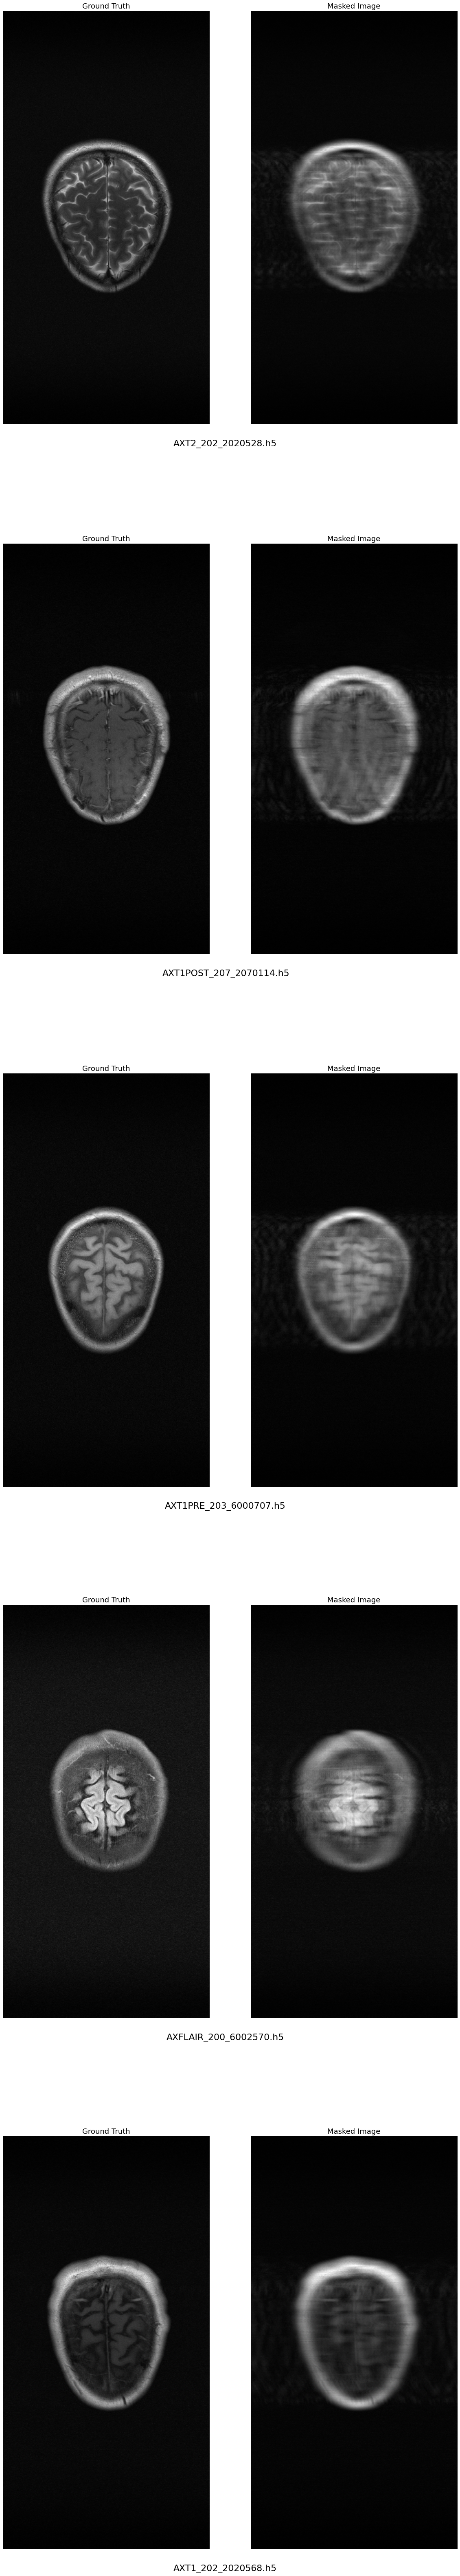

In [374]:
import fastmri
import h5py
import numpy as np
from fastmri.data import transforms as T
from fastmri.data.subsample import RandomMaskFunc
import matplotlib.pyplot as plt


fig, axs = plt.subplots(len(selected_files), 2, figsize=(20, 120))

for i, element in enumerate(selected_files):
    file_name = element
    hf = h5py.File(file_name)
    volume_kspace = hf['kspace'][()]
    slice_kspace = volume_kspace[10]
    
    slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
    slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
    slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image
    
    ground_truth = fastmri.rss(slice_image_abs, dim=0)
    axs[i, 0].imshow(np.abs(ground_truth.numpy()), cmap='gray')
    axs[i, 0].set_title(f'Ground Truth', fontsize=18)
    axs[i, 0].axis('off')
    
    mask_func = RandomMaskFunc(center_fractions=[0.04], accelerations=[4])  # Create the mask function object
    masked_kspace_4x, mask = T.apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space

    sampled_image = fastmri.ifft2c(masked_kspace_4x)           # Apply Inverse Fourier Transform to get the complex image
    sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image
    sampled_image_rss_masked_4x = fastmri.rss(sampled_image_abs, dim=0)

    axs[i, 1].imshow(np.abs(sampled_image_rss_masked_4x.numpy()), cmap='gray')
    axs[i, 1].set_title(f'Masked Image', fontsize=18, loc='center')
    axs[i, 1].axis('off')

    # Add the file name to the middle of the pair of pictures

    axs[i, 1].text(sampled_image_rss_masked_4x.shape[1]//2-200, (sampled_image_rss_masked_4x.shape[0]//2)+350, file_name[44:], fontsize=22, ha='center', va='center')

plt.subplots_adjust(wspace=0.2, hspace=0.0)  # Adjust spacing between subplots
plt.show()

In [384]:
import os
import random

folder_path = 'multicoil_values/multicoil_train'

# Define a list of substrings to search for
search_substrings = ['AXT2', 'AXT1POST', 'AXT1PRE', 'AXFLAIR', 'AXT1_']

# Define a list of files to exclude
exclude_files = ['multicoil_values/multicoil_train/file_brain_AXT2_202_2020528.h5',
                 'multicoil_values/multicoil_train/file_brain_AXT1POST_207_2070114.h5',
                 'multicoil_values/multicoil_train/file_brain_AXT1PRE_203_6000707.h5',
                 'multicoil_values/multicoil_train/file_brain_AXFLAIR_200_6002570.h5',
                 'multicoil_values/multicoil_train/file_brain_AXT1_202_2020568.h5']

# Initialize a dictionary to store the file names for each substring
file_names = {substring: [] for substring in search_substrings}

# Get a list of all files in the specified directory
file_list = os.listdir(folder_path)

# Loop through each file and append its name to the corresponding list in the file_names dictionary
for file_name in file_list:
    if file_name not in exclude_files:
        for substring in search_substrings:
            if substring in file_name.upper():
                file_names[substring].append(os.path.join(folder_path, file_name))

# Select a random file name for each substring and store it in a dictionary
selected_files = {}
for substring in search_substrings:
    if file_names[substring]:
        selected_files[substring] = random.choice(file_names[substring])
    else:
        print(f"No file found for substring '{substring}'")
        
print(selected_files)

{'AXT2': 'multicoil_values/multicoil_train/file_brain_AXT2_201_2010031.h5', 'AXT1POST': 'multicoil_values/multicoil_train/file_brain_AXT1POST_201_6002776.h5', 'AXT1PRE': 'multicoil_values/multicoil_train/file_brain_AXT1PRE_203_6000726.h5', 'AXFLAIR': 'multicoil_values/multicoil_train/file_brain_AXFLAIR_209_6001360.h5', 'AXT1_': 'multicoil_values/multicoil_train/file_brain_AXT1_202_2020134.h5'}


/tmp/ipykernel_8875/2211853240.py:13: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  hf = h5py.File(file_name)


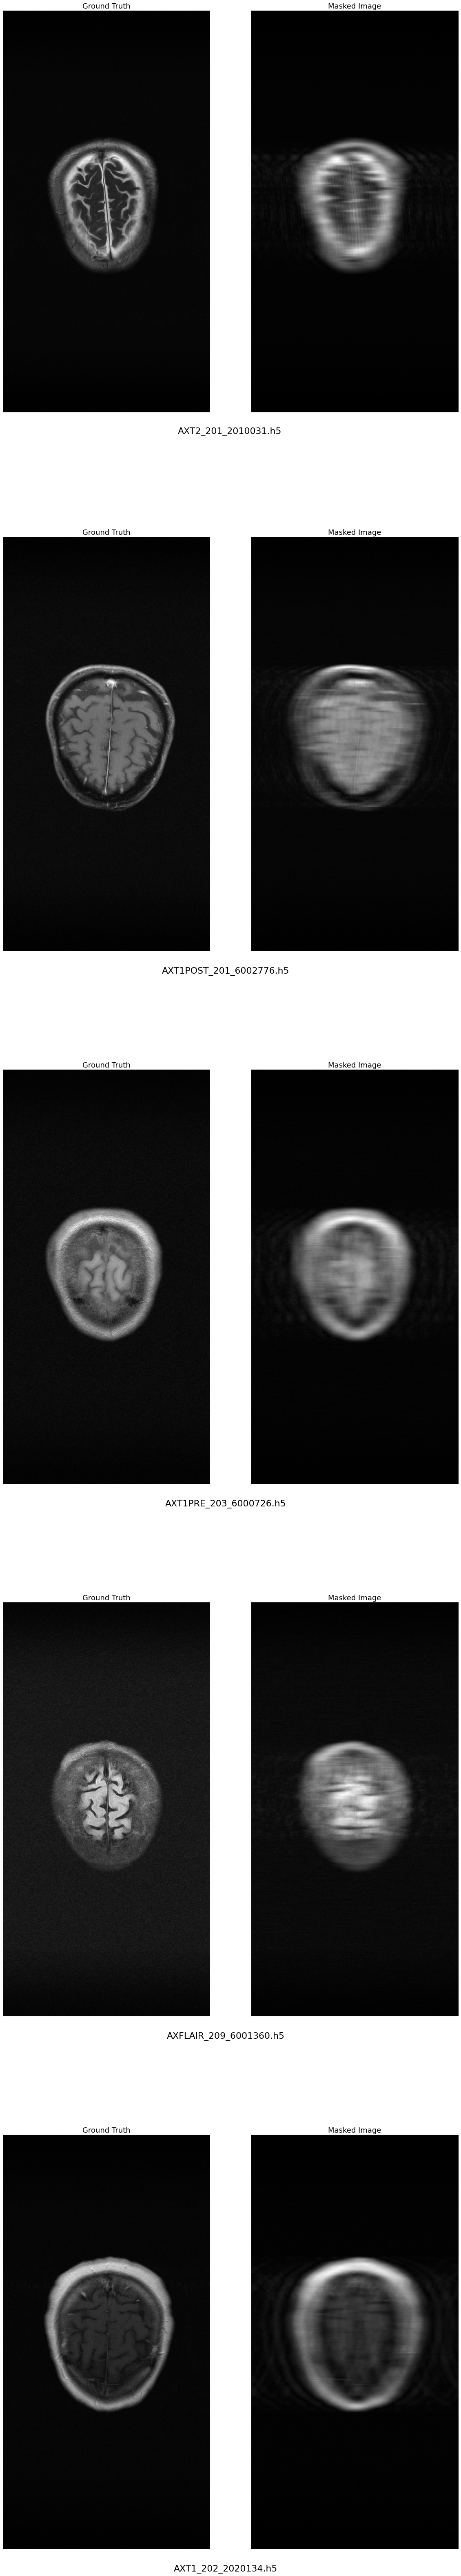

In [397]:
import fastmri
import h5py
import numpy as np
from fastmri.data import transforms as T
from fastmri.data.subsample import RandomMaskFunc
import matplotlib.pyplot as plt


fig, axs = plt.subplots(len(selected_files), 2, figsize=(20, 120))

for i, element in enumerate(selected_files.values()):
    file_name = element
    hf = h5py.File(file_name)
    volume_kspace = hf['kspace'][()]
    slice_kspace = volume_kspace[10]
    
    slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
    slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
    slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image
    
    ground_truth = fastmri.rss(slice_image_abs, dim=0)
    axs[i, 0].imshow(np.abs(ground_truth.numpy()), cmap='gray')
    axs[i, 0].set_title(f'Ground Truth', fontsize=18)
    axs[i, 0].axis('off')
    
    mask_func = RandomMaskFunc(center_fractions=[0.04], accelerations=[8])  # Create the mask function object
    masked_kspace_8x, mask = T.apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space

    sampled_image = fastmri.ifft2c(masked_kspace_8x)           # Apply Inverse Fourier Transform to get the complex image
    sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image
    sampled_image_rss_masked_8x = fastmri.rss(sampled_image_abs, dim=0)

    axs[i, 1].imshow(np.abs(sampled_image_rss_masked_8x.numpy()), cmap='gray')
    axs[i, 1].set_title(f'Masked Image', fontsize=18, loc='center')
    axs[i, 1].axis('off')

    # Add the file name to the middle of the pair of pictures
    if i==0:
        axs[0, 1].text(sampled_image_rss_masked_8x.shape[1]//2-240, (sampled_image_rss_masked_8x.shape[0]//2)+420, file_name[44:], fontsize=22, ha='center', va='center')
    else:
        axs[i, 1].text(sampled_image_rss_masked_8x.shape[1]//2-200, (sampled_image_rss_masked_8x.shape[0]//2)+350, file_name[44:], fontsize=22, ha='center', va='center')
    

plt.subplots_adjust(wspace=0.2, hspace=0.0)  # Adjust spacing between subplots
plt.show()

In [398]:
import torch
torch.cuda.is_available()
torch.cuda.device_count()
torch.cuda.current_device()
torch.cuda.device(0)
torch.cuda.get_device_name(0)


'Tesla V100-SXM2-32GB'